In [3]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

stanford-dogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
! mkdir Dogs

mkdir: cannot create directory ‘Dogs’: File exists


In [ ]:
! unzip stanford-dogs-dataset.zip -d Dogs

In [68]:
import os, shutil

path_name = './Dogs/images/Images'
dir_length = len(os.listdir(path_name))
# Because os.listdir doesn't traverse through a directory alphanumerically (it's not guaranteed)
# we need to sort through it by first saving all possible dir in a list
# and then sorting it in ascending order
folder_names_alphabetical_order = os.listdir(path_name)
folder_names_alphabetical_order.sort()
print(dir_length, folder_names_alphabetical_order)

120 ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshi

In [57]:
dog_classes = {}
for i, name in enumerate(folder_names_alphabetical_order):
  dog_classes[i] = name[10:]

print(len(dog_classes), dog_classes)

120 {0: 'Chihuahua', 1: 'Japanese_spaniel', 2: 'Maltese_dog', 3: 'Pekinese', 4: 'Shih-Tzu', 5: 'Blenheim_spaniel', 6: 'papillon', 7: 'toy_terrier', 8: 'Rhodesian_ridgeback', 9: 'Afghan_hound', 10: 'basset', 11: 'beagle', 12: 'bloodhound', 13: 'bluetick', 14: 'black-and-tan_coonhound', 15: 'Walker_hound', 16: 'English_foxhound', 17: 'redbone', 18: 'borzoi', 19: 'Irish_wolfhound', 20: 'Italian_greyhound', 21: 'whippet', 22: 'Ibizan_hound', 23: 'Norwegian_elkhound', 24: 'otterhound', 25: 'Saluki', 26: 'Scottish_deerhound', 27: 'Weimaraner', 28: 'Staffordshire_bullterrier', 29: 'American_Staffordshire_terrier', 30: 'Bedlington_terrier', 31: 'Border_terrier', 32: 'Kerry_blue_terrier', 33: 'Irish_terrier', 34: 'Norfolk_terrier', 35: 'Norwich_terrier', 36: 'Yorkshire_terrier', 37: 'wire-haired_fox_terrier', 38: 'Lakeland_terrier', 39: 'Sealyham_terrier', 40: 'Airedale', 41: 'cairn', 42: 'Australian_terrier', 43: 'Dandie_Dinmont', 44: 'Boston_bull', 45: 'miniature_schnauzer', 46: 'giant_schnau

In [13]:
import numpy as np
import torch
import cv2
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
%matplotlib inline

Text(0, 0.5, 'Image Count')

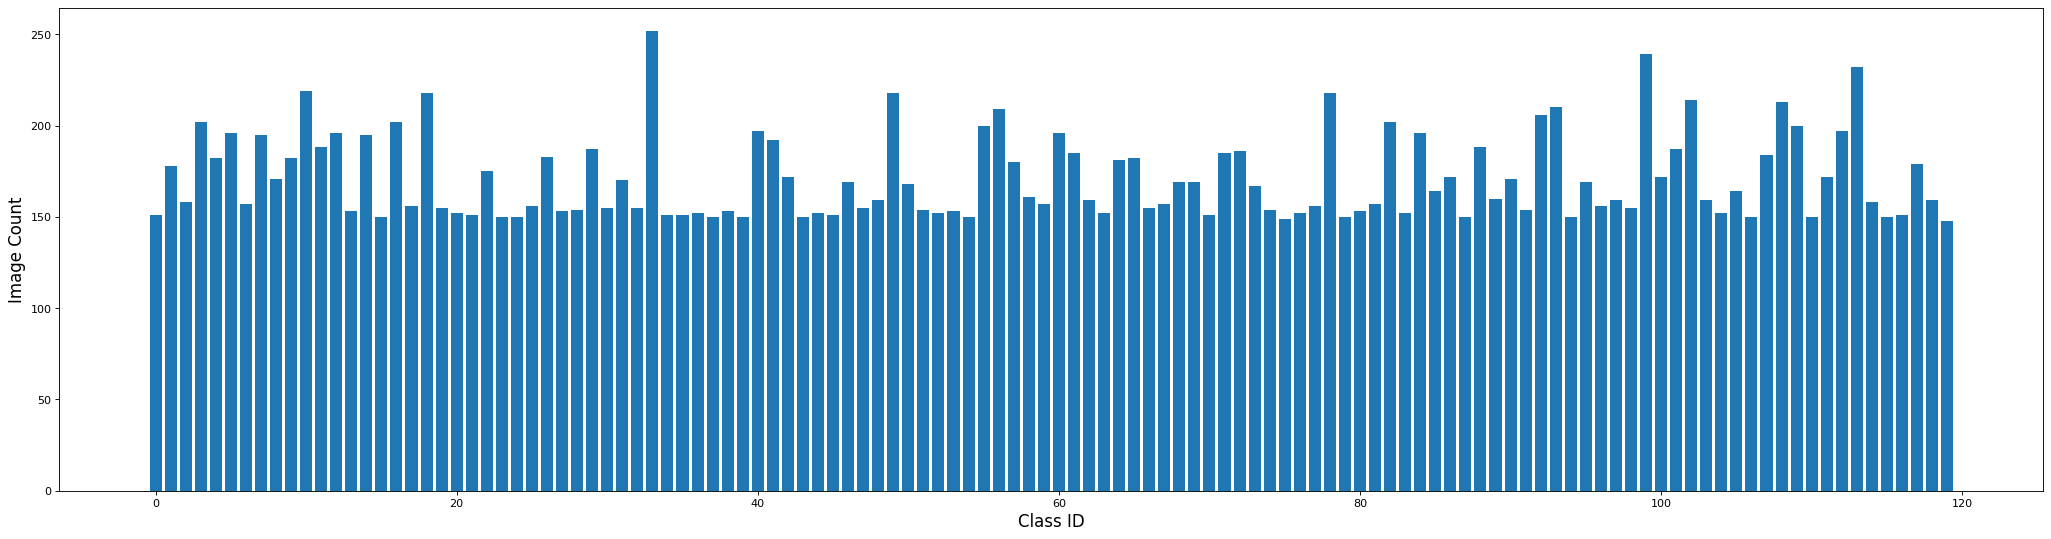

In [58]:
# get image data & labels
class_list = os.listdir(path_name)
image_dataset = []
label_dataset = []
class_ID = 0
image_count = 0

for current_class in class_list:
  for image in os.listdir(path_name+'/'+current_class):
    image_count+=1
  image_dataset.append(image_count)
  label_dataset.append(class_ID)
  class_ID += 1
  image_count = 0

plt.figure(figsize=(32,8), dpi=80)
plt.bar(label_dataset, height=image_dataset)
plt.xlabel('Class ID', fontsize=15)
plt.ylabel('Image Count', fontsize=15)

In [15]:
image_size = 224

In [64]:
# Data Transforms
"""
train_data_transform = transforms.Compose([
                                           transforms.RandomResizedCrop(image_size),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor()
])
valid_data_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor()
])
"""
data_transform = {
    'train':
    transforms.Compose([
                        transforms.RandomResizedCrop(image_size),
                        transforms.RandomHorizontalFlip(),
                        transforms.ColorJitter(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225]),
                        transforms.ToTensor()
    ]),
    'test':
    transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.CenterCrop(224),
                        transforms.ToTensor()
    ])
}

In [65]:
"""
Split the images into train, validation and test sets
"""
"""
# Form the dataset class from the dogs folder
dataset = torchvision.datasets.ImageFolder(
    root=path_name,
    transform=train_data_transform
)

# Determine the split ratio between the train/validation/test dataset
train_portion, valid_portion, test_portion = 0.8, 0.1, 0.1

# Count the no. images
train_count = int(len(dataset)*train_portion)
valid_count = int(len(dataset)*valid_portion)
test_count = int(len(dataset)*test_portion)

# random spread the images
indices = torch.randperm(len(dataset))

train_indices = indices[0:train_count]
valid_indices = indices[train_count:valid_count]
test_indices = indices[train_count+valid_count:]
"""

all_data = torchvision.datasets.ImageFolder(
    root=path_name
)

train_data_len = int(len(all_data)*0.9)
valid_data_len = int(len(all_data)*0.05)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)

# Need to try Stratified sampling as well
# to make sure each class is evenly split among train/valid/test samples
train_data, valid_data, test_data = torch.utils.data.random_split(
    all_data,
    [train_data_len, valid_data_len, test_data_len]
)

train_data.dataset.transform = data_transform['train']
valid_data.dataset.transform = data_transform['test']
test_data.dataset.transform = data_transform['test']
print(len(train_data), len(valid_data), len(test_data))

18522 1029 1029


In [66]:
# DataLoader
# Note: Using sampler means the shuffle option is not needed.
"""
train_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    sampler=torch.utils.data.SubsetRandomSampler(train_indices),
    batch_size=32,
    drop_last=True,
)
valid_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    sampler=torch.utils.data.SubsetRandomSampler(valid_indices),
    batch_size=16,
)
test_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    sampler=torch.utils.data.SubsetRandomSampler(test_indices),
    batch_size=16
)
"""

train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=False
)
valid_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=False
)

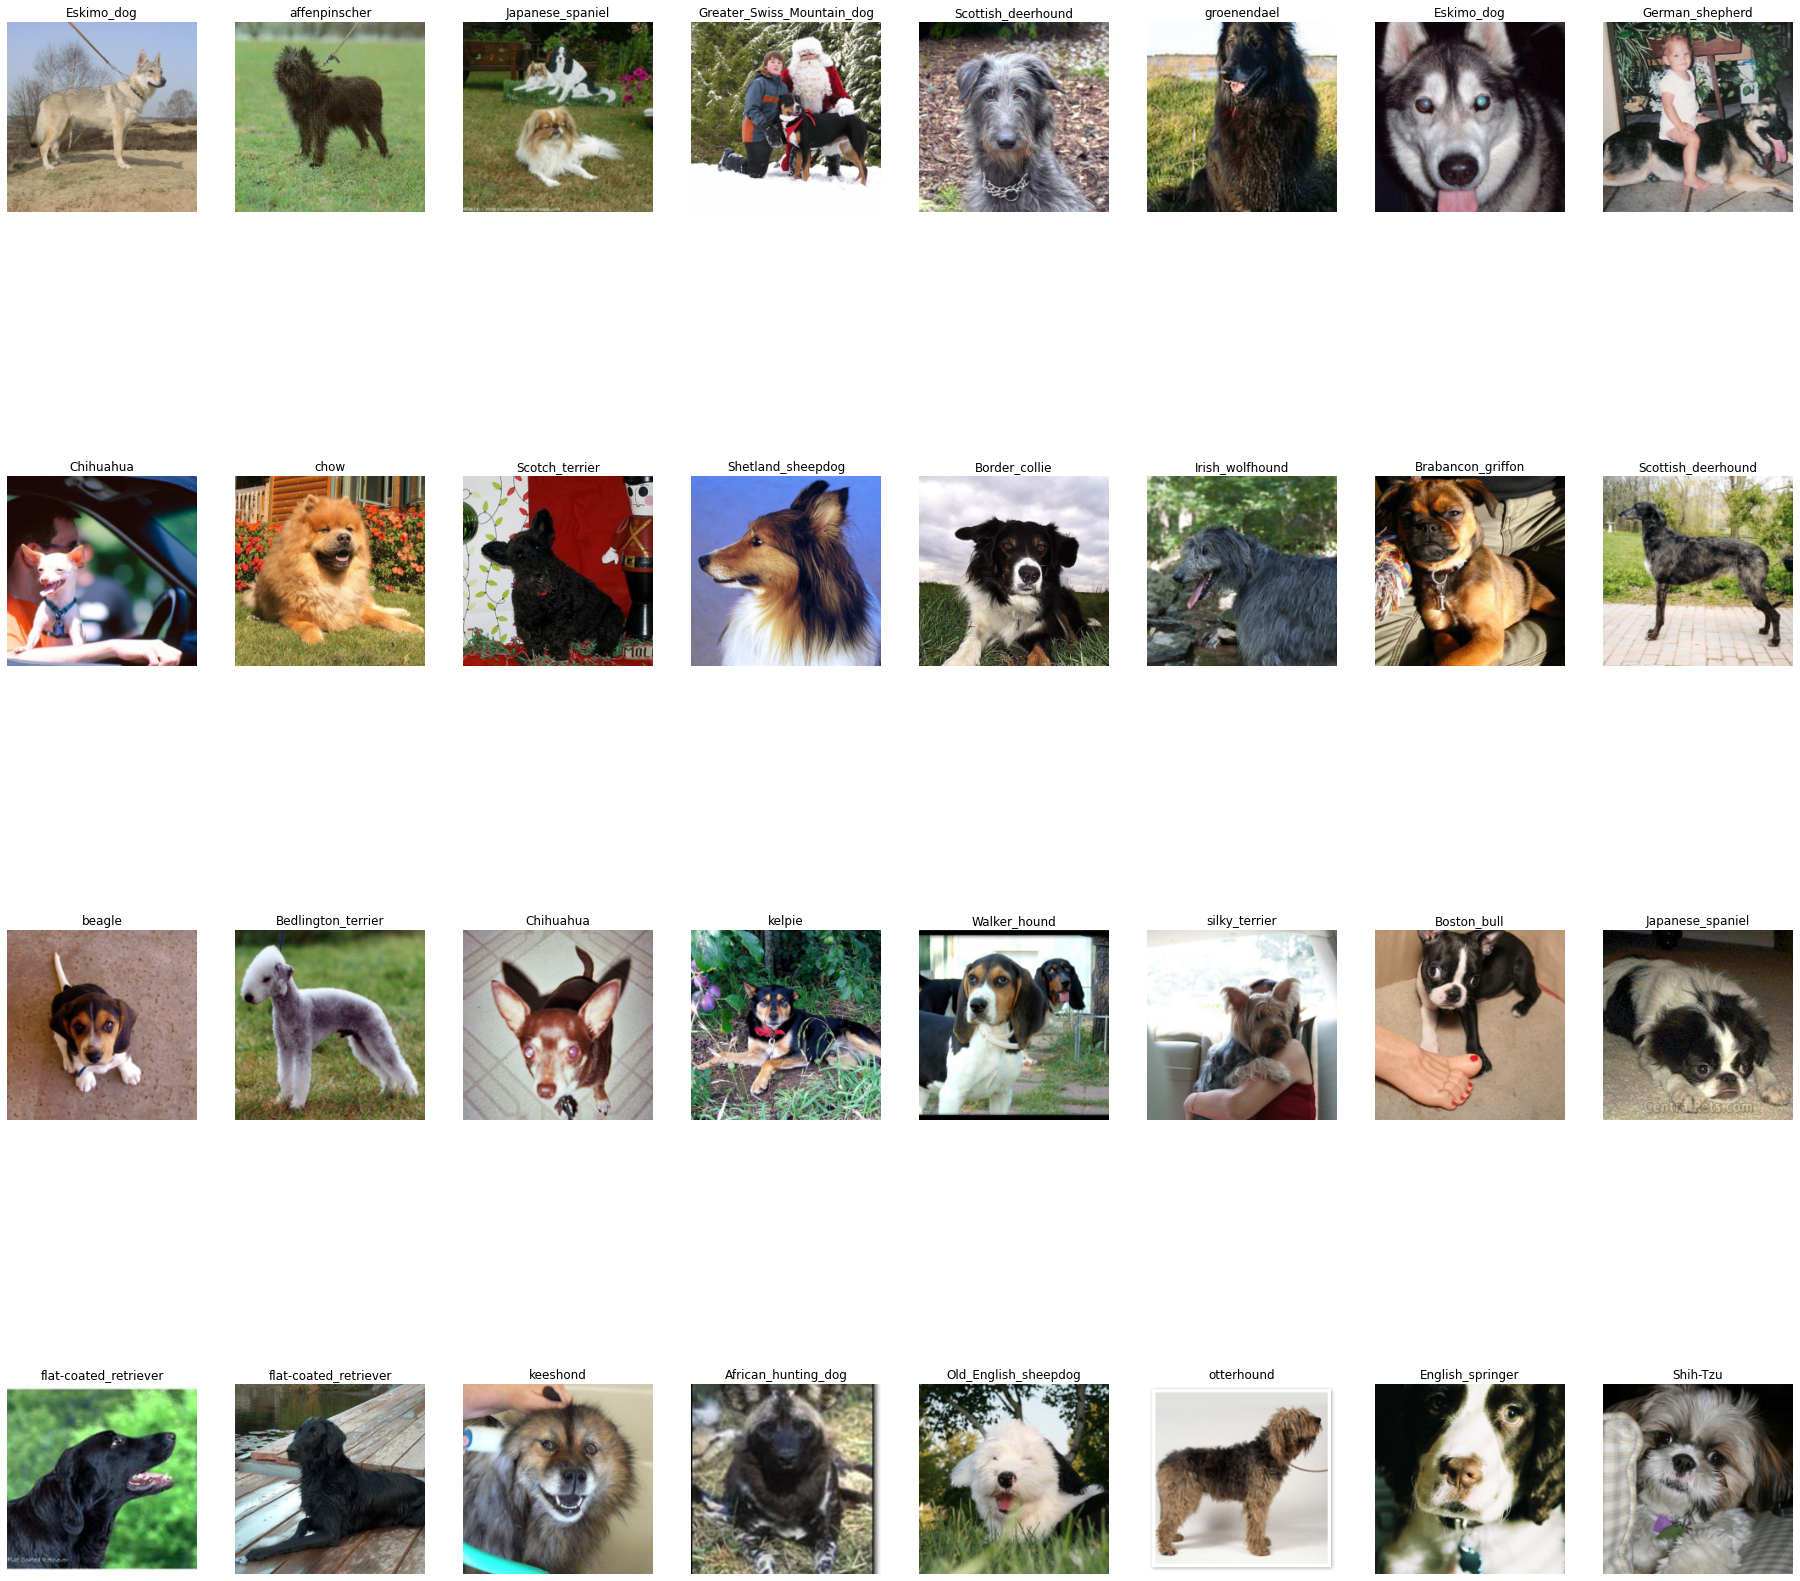

In [67]:
samples, labels = iter(train_loader).next()
labels = [l.item() for l in labels[:32]]
plt.figure(figsize=(32,32))
plt.tight_layout()
for i, sample in enumerate(samples[:32]):
  plt.subplot(4, 8, i+1)
  plt.title(dog_classes[labels[i]])
  plt.axis('off')
  sample = sample.numpy()
  plt.imshow(np.transpose(sample, (1,2,0)))

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [70]:
model = torchvision.models.resnet50(pretrained=True)

In [71]:
for param in model.parameters():
  param.require_grad = False

In [72]:
input_features = model.fc.in_features
print(input_features)
# Note: Try without dropout to see if it alleviates the underfitting problem
new_fc = nn.Sequential(
    nn.Linear(input_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    #nn.Dropout(0.5),
    nn.Linear(512, len(dog_classes)),
    nn.LogSoftmax(dim=1)
)

model.fc = new_fc

2048


In [73]:
criterion = nn.NLLLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=4e-4)

In [74]:
epochs = 10
total_step = len(train_loader)
model.to(device)
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
train_total_loss = 0
train_acc = 0
val_acc, val_loss = 0, 0
per_iteration = 100
print(total_step)

290


In [75]:
for epoch in range(epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    #Forward Pass
    model.train()
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backpass and Optimise
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    train_total_loss += loss.item()

    if (i+1)%per_iteration == 0 or (i+1) == total_step:
    #if (i+1) == total_step:
      # Train
      _, pred = torch.max(outputs, dim=1)
      train_acc = (pred.data == labels.data).sum()/len(pred)

      # Validation
      model.eval()
      with torch.no_grad():
        val_correct = 0
        val_total = 0
        val_len = len(valid_loader)
        total = 0
        val_loss_temp = 0
        #for imgs, labs in test_loader:
        for imgs, labs in valid_loader:
          imgs = imgs.to(device)
          labs = labs.to(device)
          val_outputs = model(imgs)
          val_loss1 = criterion(val_outputs, labs)
          predicted = torch.argmax(val_outputs, dim=1)
          val_correct += (predicted == labs).sum()
          val_loss_temp += val_loss1.item()
          total += len(predicted)
        val_acc = val_correct/total
        val_loss = val_loss_temp/total
      
      print('Epoch: {}/{}, Step: {}/{}, Train_Loss: {:.4f}, Train_Acc: {:.4f}, Val_Loss: {:.4f}, Val_Acc: {:.4f}'.format(epoch+1, epochs, i+1, total_step, train_total_loss/per_iteration, train_acc, val_loss, val_acc))

      train_loss_list.append(train_total_loss/per_iteration)
      train_acc_list.append(train_acc)
      val_loss_list.append(val_loss)
      val_acc_list.append(val_acc)
      train_total_loss = 0
      train_acc = 0
      val_acc = 0
      val_loss = 0

Epoch: 1/10, Step: 100/290, Train_Loss: 3.5275, Train_Acc: 0.5781, Val_Loss: 0.0304, Val_Acc: 0.5333
Epoch: 1/10, Step: 146/290, Train_Loss: 0.7771, Train_Acc: 0.6406, Val_Loss: 0.0193, Val_Acc: 0.6657
Epoch: 1/10, Step: 200/290, Train_Loss: 0.7071, Train_Acc: 0.7031, Val_Loss: 0.0144, Val_Acc: 0.7452
Epoch: 2/10, Step: 100/290, Train_Loss: 1.6922, Train_Acc: 0.8906, Val_Loss: 0.0074, Val_Acc: 0.8592
Epoch: 2/10, Step: 146/290, Train_Loss: 0.2354, Train_Acc: 0.8281, Val_Loss: 0.0065, Val_Acc: 0.8706
Epoch: 2/10, Step: 200/290, Train_Loss: 0.2548, Train_Acc: 0.8906, Val_Loss: 0.0055, Val_Acc: 0.8862
Epoch: 3/10, Step: 100/290, Train_Loss: 0.6816, Train_Acc: 0.9531, Val_Loss: 0.0039, Val_Acc: 0.9250
Epoch: 3/10, Step: 146/290, Train_Loss: 0.1016, Train_Acc: 0.9062, Val_Loss: 0.0038, Val_Acc: 0.9212
Epoch: 3/10, Step: 200/290, Train_Loss: 0.1137, Train_Acc: 0.9375, Val_Loss: 0.0040, Val_Acc: 0.9217
Epoch: 4/10, Step: 100/290, Train_Loss: 0.3798, Train_Acc: 0.9531, Val_Loss: 0.0029, Val_Ac

<function matplotlib.pyplot.show>

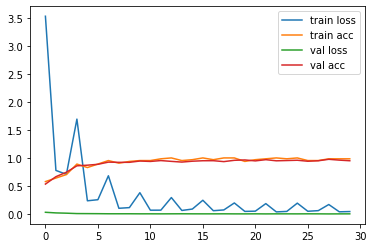

In [76]:
plt.plot(train_loss_list, label='train loss')
plt.plot(train_acc_list, label='train acc')
plt.plot(val_loss_list, label='val loss')
plt.plot(val_acc_list, label='val acc')
l1 = plt.legend(loc="best")
plt.show

In [77]:
# Testing the model
test_acc = 0;
test_loss = 0
test_total = 0
with torch.no_grad():
  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    temp_loss = criterion(outputs, labels)

    test_loss += temp_loss.item()

    _, preds = torch.max(outputs, dim=1)

    test_acc += (preds == labels).sum()
    test_total += len(images)

avg_acc = test_acc/test_total
avg_loss = test_loss/test_total

print("Test Samples Accuracy is: {:.4f}, Loss is: {:.4f}".format(avg_acc, avg_loss))

Test Samples Accuracy is: 0.9710, Loss is: 0.0014


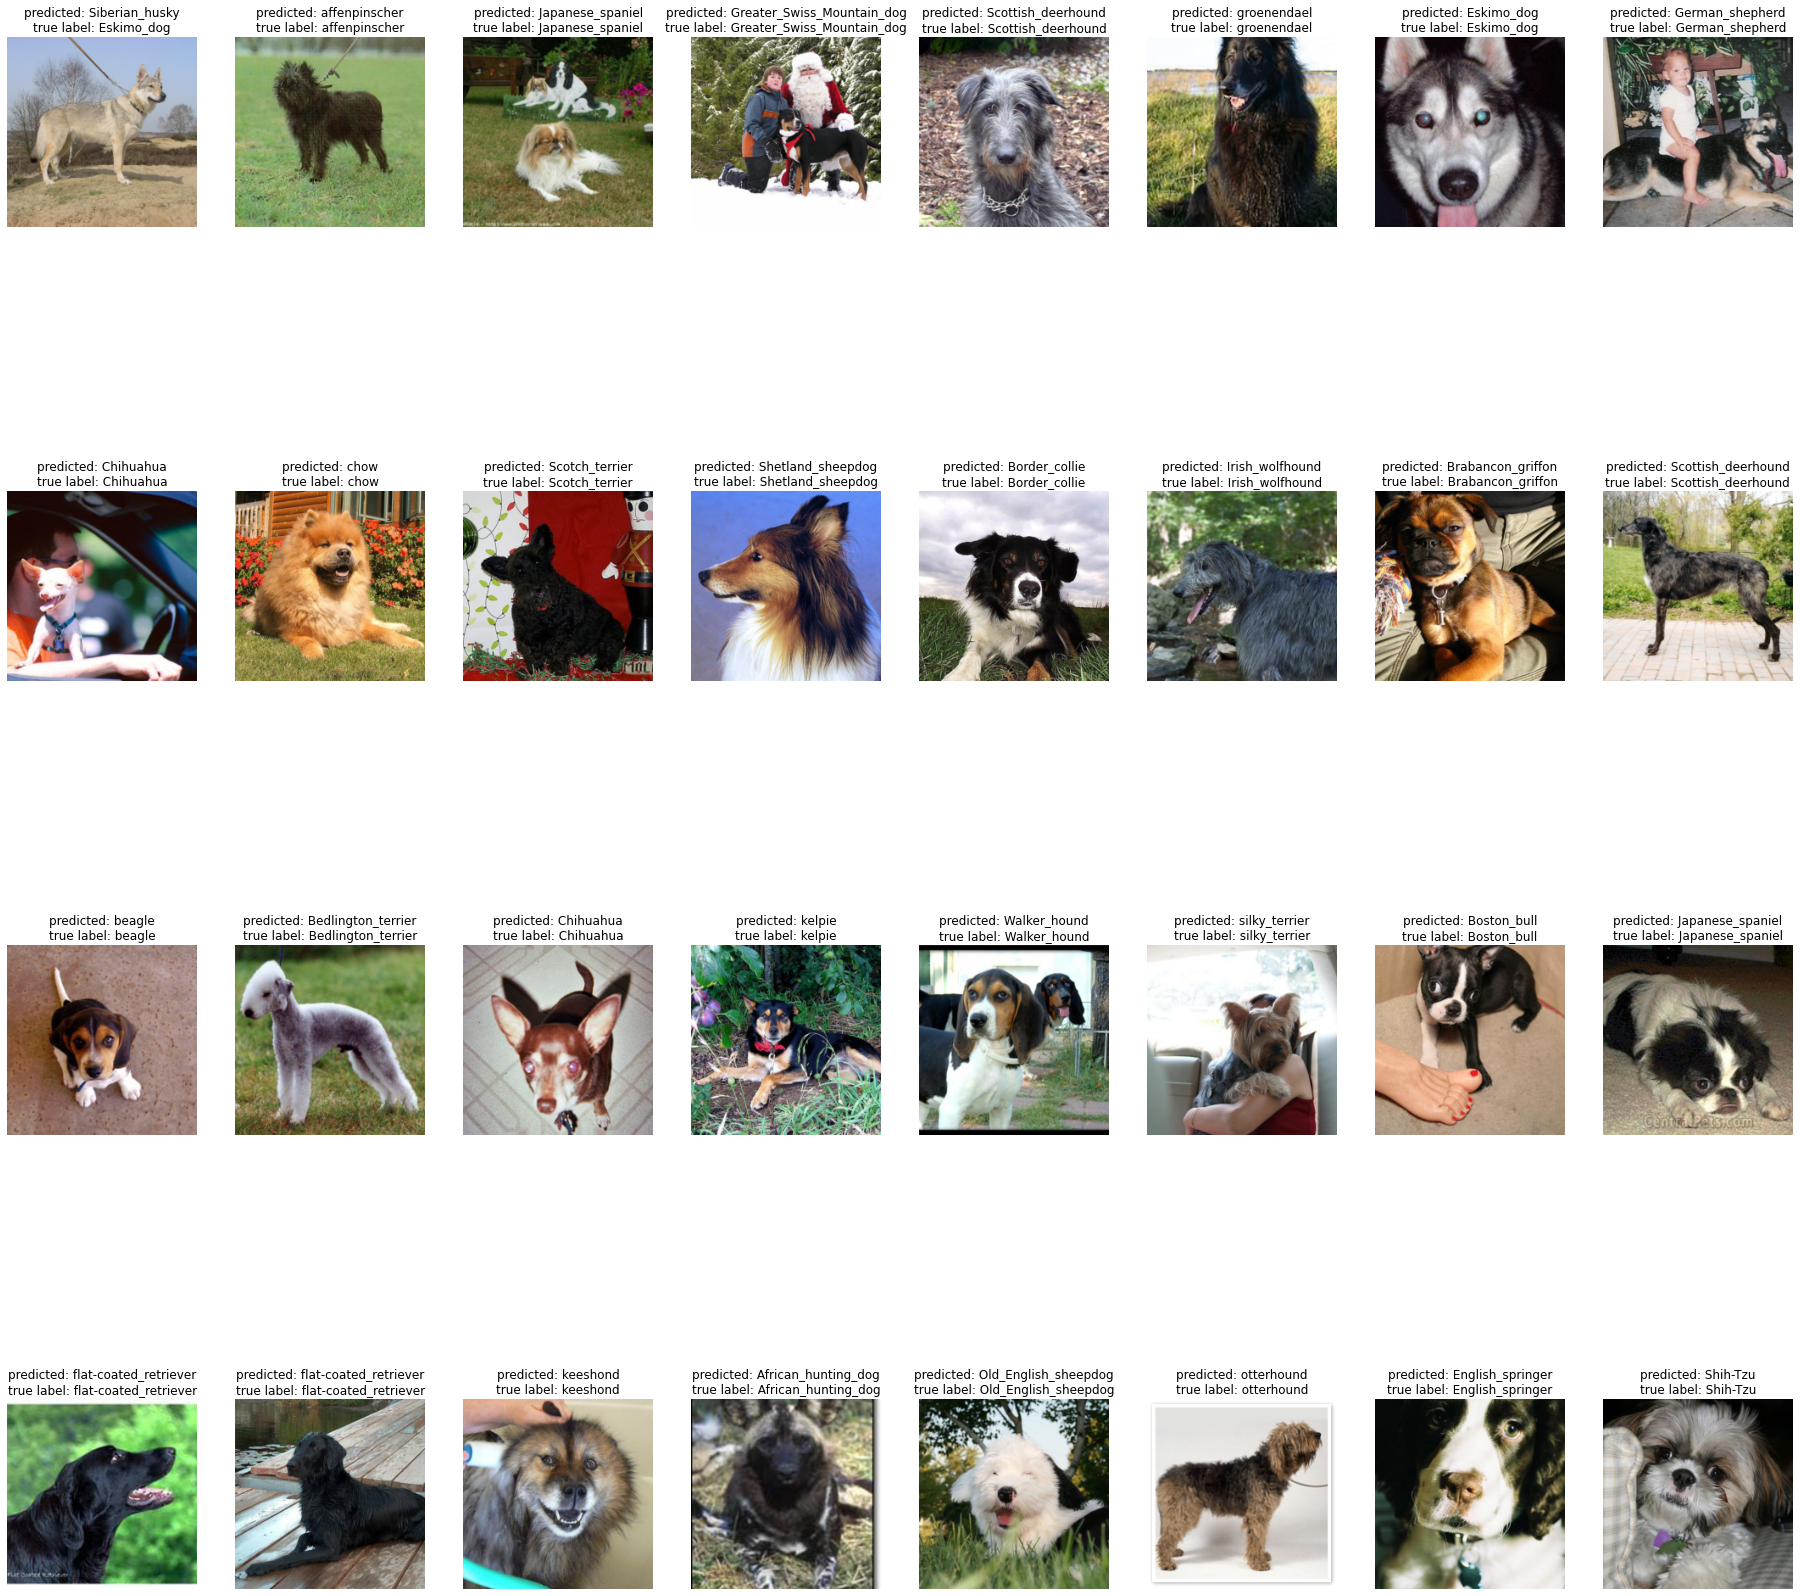

In [91]:
# Visualise the test
samples, true_label = iter(test_loader).next()
samples = samples[:32]

fig = plt.figure(figsize=(32,32))
fig.tight_layout()
output = model(samples[:32].to(device))
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred[:32]]

for i, sample in enumerate(samples[:32]):
  plt.subplot(4, 8, i+1)
  subplottitle = "predicted: " + str(dog_classes[pred[i]]) + "\ntrue label: " + dog_classes[true_label[i].item()]
  plt.title(subplottitle)
  plt.axis('off')
  sample = sample.cpu().numpy()
  plt.imshow(np.transpose(sample, (1, 2, 0)))

In [92]:
# Save the trained model
from google.colab import drive
drive.mount('/content/gdrive')

modelname = 'model_resnet50_Stanford_Dog.ckpt'
path = F"/content/gdrive/My Drive/{modelname}"
torch.save(model.state_dict(), path)

Mounted at /content/gdrive
